In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import csv
import functools
import warnings
warnings.filterwarnings('ignore') 


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)
pd.set_option('display.max_rows', 150)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16,10)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import pickle
from collections import OrderedDict


from RemoteQuery import *
from utils import *

**EDA for the printed output**

In [16]:
res = pd.read_table("./data/result_000776_2.txt", header=None, names=['result'])
res.head()

,result
0,maximum lead correlation of pair (000776 vs 00...
1,minimum lead correlation of pair (000776 vs 00...
2,maximum lag correlation of pair (000776 vs 000...
3,minimum lag correlation of pair (000776 vs 000...
4,Original correlation of pair (000776 vs 000166...


In [17]:
max_leadlag = res[res['result'].str.startswith('maximum')].reset_index(drop=True)
min_leadlag = res[res['result'].str.startswith('minimum')].reset_index(drop=True)
error_stock1 = res[res['result'].str.startswith('Data')].reset_index(drop=True)
error_stock2 = res[res['result'].str.startswith('Fail')].reset_index(drop=True)
llr = res[res['result'].str.startswith('Lead/lag')].reset_index(drop=True)
ori = res[res['result'].str.startswith('Original')].reset_index(drop=True)

In [18]:
llr.shape[0] + error_stock1.shape[0] + error_stock2.shape[0]

300

In [5]:
# error_stock1.iloc[0]['result']
# error_stock2.iloc[0]['result']

In [7]:
error_stock1['result'] = error_stock1['result'].str[18:36].apply(lambda x: ','.join(x.split(' vs ')))
error_stock2['result'] = error_stock2['result'].str[-18:].apply(lambda x: ','.join(x.split(' vs ')))

error_stock1.head()
error_stock2.head()

,result


,result


In [8]:
max_leadlag.iloc[0]['result']

'maximum lead correlation of pair (000776 vs 000166) (lead = 0:00:01): 0.2502787279641703'

In [9]:
min_leadlag.iloc[0]['result']

'minimum lead correlation of pair (000776 vs 000166) (lead = 0:05:00): 0.015974187332821833'

In [19]:
max_leadlag['r_index'] = max_leadlag['result'].str.find(')')
max_leadlag['l_index'] = max_leadlag['result'].str.find('(')
max_leadlag['r1_index'] = max_leadlag['result'].str.find('=')
max_leadlag['l1_index'] = max_leadlag['result'].str.find(': ')

max_leadlag['pair'] = max_leadlag.apply(lambda x: x['result'][x['l_index']+1:x['r_index']], axis=1)
max_leadlag['pair'] = max_leadlag['pair'].apply(lambda x: '(' + ','.join(x.split(' vs ')) + ')')
max_leadlag['option'] = np.where(max_leadlag['result'].str.contains('lead'),'lead', 'lag')

max_leadlag['leadlagtime'] = max_leadlag.apply(lambda x: x['result'][x['r1_index']+2:x['l1_index']-1], axis=1)
max_leadlag['corr']  = max_leadlag.apply(lambda x: x['result'][x['l1_index']+2:], axis=1)
max_leadlag.drop(['r_index', 'r1_index', 'l_index','l1_index', 'result'], axis=1, inplace=True)

max_lead = max_leadlag[max_leadlag['option'] == 'lead'].reset_index(drop=True)
max_lag = max_leadlag[max_leadlag['option'] == 'lag'].reset_index(drop=True)
max_leadlag

,pair,option,leadlagtime,corr
0,"(000776,000166)",lead,0:00:01,0.2502787279641703
1,"(000776,000166)",lag,0:00:20,0.3070895549391699
2,"(000776,000725)",lead,0:00:01,0.332036866049625
3,"(000776,000725)",lag,0:00:20,0.35824395071030724
4,"(000776,000157)",lead,0:00:01,0.20526210915981047
...,...,...,...,...
595,"(000776,688396)",lag,0:00:01,0.09603409423909728
596,"(000776,688363)",lead,0:00:01,0.08038426710282488
597,"(000776,688363)",lag,0:00:01,0.07405753012592638
598,"(000776,688599)",lead,0:00:01,0.056506326587658556


In [20]:
min_leadlag['r_index'] = min_leadlag['result'].str.find(')')
min_leadlag['l_index'] = min_leadlag['result'].str.find('(')
min_leadlag['r1_index'] = min_leadlag['result'].str.find('=')
min_leadlag['l1_index'] = min_leadlag['result'].str.find(': ')

min_leadlag['pair'] = min_leadlag.apply(lambda x: x['result'][x['l_index']+1:x['r_index']], axis=1)
min_leadlag['pair'] = min_leadlag['pair'].apply(lambda x: '(' + ','.join(x.split(' vs ')) + ')')
min_leadlag['option'] = np.where(min_leadlag['result'].str.contains('lead'),'lead', 'lag')

min_leadlag['leadlagtime'] = min_leadlag.apply(lambda x: x['result'][x['r1_index']+2:x['l1_index']-1], axis=1)
min_leadlag['corr']  = min_leadlag.apply(lambda x: x['result'][x['l1_index']+2:], axis=1)
min_leadlag.drop(['r_index', 'r1_index', 'l_index','l1_index', 'result'], axis=1, inplace=True)

min_lead = min_leadlag[min_leadlag['option'] == 'lead'].reset_index(drop=True)
min_lag = min_leadlag[min_leadlag['option'] == 'lag'].reset_index(drop=True)
min_leadlag

,pair,option,leadlagtime,corr
0,"(000776,000166)",lead,0:05:00,0.015974187332821833
1,"(000776,000166)",lag,0:05:00,0.06942722531668609
2,"(000776,000725)",lead,0:05:00,0.042655478585873825
3,"(000776,000725)",lag,0:05:00,0.1180698129976016
4,"(000776,000157)",lead,0:03:00,0.0037501793326218274
...,...,...,...,...
595,"(000776,688396)",lag,0:03:00,-0.007735655709774003
596,"(000776,688363)",lead,0:01:00,-0.008664408225335046
597,"(000776,688363)",lag,0:02:00,-0.0045861133950545006
598,"(000776,688599)",lead,0:00:15,-0.0019015559780004526


In [21]:
llr['pair'] = llr['result'].str[24:40].apply(lambda x: '(' + ','.join(x.split(' vs ')) + ')')
llr['llr'] = llr['result'].str[43:].astype(float)
llr.drop(['result'], axis=1, inplace=True)
llr.head()

,pair,llr
0,"(000776,000166)",0.322835
1,"(000776,000725)",0.532163
2,"(000776,000157)",0.737268
3,"(000776,000425)",0.536392
4,"(000776,002024)",0.130475


In [22]:
ori['pair'] = ori['result'].str[30:46].apply(lambda x: '(' + ','.join(x.split(' vs ')) + ')')
ori['ori'] = ori['result'].str[49:].astype(float)
ori.drop(['result'], axis=1, inplace=True)
ori.head()

,pair,ori
0,"(000776,000166)",0.242427
1,"(000776,000725)",0.334727
2,"(000776,000157)",0.187492
3,"(000776,000425)",0.160901
4,"(000776,002024)",0.023405


In [23]:
max_lead.set_index('pair', inplace=True)
max_lag.set_index('pair', inplace=True)
min_lead.set_index('pair', inplace=True)
min_lag.set_index('pair', inplace=True)
llr.set_index('pair', inplace=True)
ori.set_index('pair', inplace=True)

In [24]:
result = pd.concat([llr, max_lead, max_lag, min_lead, min_lag, ori], axis=1).reset_index(drop=False)
result.drop(['option'], axis=1, inplace=True)
result.columns = ['pair', 'llr', 'max_lead_time', 'max_lead_corr', 'max_lag_time', 'max_lag_corr', 'min_lead_time', 'min_lead_corr', 'min_lag_time', 'min_lag_corr', 'ori_corr']
result['asset1'] = result['pair'].str[1:-1].str.split(',').str[0]
result['asset2'] = result['pair'].str[1:-1].str.split(',').str[1]
result

,pair,llr,max_lead_time,max_lead_corr,max_lag_time,max_lag_corr,min_lead_time,min_lead_corr,min_lag_time,min_lag_corr,ori_corr,asset1,asset2
0,"(000776,000166)",0.322835,0:00:01,0.2502787279641703,0:00:20,0.3070895549391699,0:05:00,0.015974187332821833,0:05:00,0.06942722531668609,0.242427,000776,000166
1,"(000776,000725)",0.532163,0:00:01,0.332036866049625,0:00:20,0.35824395071030724,0:05:00,0.042655478585873825,0:05:00,0.1180698129976016,0.334727,000776,000725
2,"(000776,000157)",0.737268,0:00:01,0.20526210915981047,0:00:01,0.2039547071906391,0:03:00,0.0037501793326218274,0:05:00,0.008222870279785292,0.187492,000776,000157
3,"(000776,000425)",0.536392,0:00:01,0.1720146062427348,0:00:04,0.178003196298023,0:05:00,-0.0008632201881488245,0:05:00,0.022371789876211384,0.160901,000776,000425
4,"(000776,002024)",0.130475,0:00:01,0.02315106476981502,0:00:01,0.003974303471295362,0:04:00,-0.035933082137081754,0:05:00,-0.11017486389972476,0.023405,000776,002024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,"(000776,688561)",0.943563,0:00:01,0.08432071643281669,0:00:01,0.07517726011985652,0:01:00,-0.0013035553070062963,0:05:00,0.013436647010677535,0.078635,000776,688561
296,"(000776,688981)",1.363946,0:00:04,0.10420883544386524,0:00:01,0.09290301253088754,0:04:00,0.015230642266194014,0:04:00,-0.0041942845625363824,0.094875,000776,688981
297,"(000776,688396)",1.373906,0:00:01,0.10389929442247943,0:00:01,0.09603409423909728,0:03:00,7.865200183230844e-05,0:03:00,-0.007735655709774003,0.101884,000776,688396
298,"(000776,688363)",1.203063,0:00:01,0.08038426710282488,0:00:01,0.07405753012592638,0:01:00,-0.008664408225335046,0:02:00,-0.0045861133950545006,0.076583,000776,688363


In [25]:
result[['llr', 'max_lead_corr', 'min_lead_corr', 'max_lag_corr', 'min_lag_corr', 'ori_corr']] = result[['llr', 'max_lead_corr', 'min_lead_corr', 'max_lag_corr', 'min_lag_corr', 'ori_corr']].astype(float)
result['max_lead_time'] = result['max_lead_time'].apply(lambda x: pd.Timedelta(x))
result['max_lag_time'] = result['max_lag_time'].apply(lambda x: pd.Timedelta(x))
result['min_lead_time'] = result['min_lead_time'].apply(lambda x: pd.Timedelta(x))
result['min_lag_time'] = result['min_lag_time'].apply(lambda x: pd.Timedelta(x))
result

,pair,llr,max_lead_time,max_lead_corr,max_lag_time,max_lag_corr,min_lead_time,min_lead_corr,min_lag_time,min_lag_corr,ori_corr,asset1,asset2
0,"(000776,000166)",0.322835,0 days 00:00:01,0.250279,0 days 00:00:20,0.307090,0 days 00:05:00,0.015974,0 days 00:05:00,0.069427,0.242427,000776,000166
1,"(000776,000725)",0.532163,0 days 00:00:01,0.332037,0 days 00:00:20,0.358244,0 days 00:05:00,0.042655,0 days 00:05:00,0.118070,0.334727,000776,000725
2,"(000776,000157)",0.737268,0 days 00:00:01,0.205262,0 days 00:00:01,0.203955,0 days 00:03:00,0.003750,0 days 00:05:00,0.008223,0.187492,000776,000157
3,"(000776,000425)",0.536392,0 days 00:00:01,0.172015,0 days 00:00:04,0.178003,0 days 00:05:00,-0.000863,0 days 00:05:00,0.022372,0.160901,000776,000425
4,"(000776,002024)",0.130475,0 days 00:00:01,0.023151,0 days 00:00:01,0.003974,0 days 00:04:00,-0.035933,0 days 00:05:00,-0.110175,0.023405,000776,002024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,"(000776,688561)",0.943563,0 days 00:00:01,0.084321,0 days 00:00:01,0.075177,0 days 00:01:00,-0.001304,0 days 00:05:00,0.013437,0.078635,000776,688561
296,"(000776,688981)",1.363946,0 days 00:00:04,0.104209,0 days 00:00:01,0.092903,0 days 00:04:00,0.015231,0 days 00:04:00,-0.004194,0.094875,000776,688981
297,"(000776,688396)",1.373906,0 days 00:00:01,0.103899,0 days 00:00:01,0.096034,0 days 00:03:00,0.000079,0 days 00:03:00,-0.007736,0.101884,000776,688396
298,"(000776,688363)",1.203063,0 days 00:00:01,0.080384,0 days 00:00:01,0.074058,0 days 00:01:00,-0.008664,0 days 00:02:00,-0.004586,0.076583,000776,688363


In [13]:
# result.to_csv("600837.csv", index=False)

In [14]:
from utils import *
date = '20220601'
stock_list = get_stock_list(date)
stock_list[:5]

Total number of stocks: 4723


['000001', '000002', '000004', '000005', '000006']

In [20]:
result = result[result['asset2'].isin(stock_list)]

In [21]:
result.shape

(4573, 9)

In [14]:
result.head()

,pair,llr,lead_time,max_lead_corr,lag_time,max_lag_corr,ori_corr,asset1,asset2
0,"(000776,000725)",0.748336,0 days 00:00:01,0.086499,0 days 00:00:01,0.092644,0.087247,000776,000725
1,"(000776,000166)",0.682556,0 days 00:00:01,0.078766,0 days 00:00:07,0.083270,0.076472,000776,000166
2,"(000776,000425)",0.773478,0 days 00:00:01,0.062007,0 days 00:00:04,0.064559,0.060225,000776,000425
3,"(000776,000157)",0.886804,0 days 00:00:01,0.062315,0 days 00:00:04,0.063611,0.057782,000776,000157
4,"(000776,000783)",0.626555,0 days 00:00:01,0.078740,0 days 00:00:06,0.095201,0.074672,000776,000783


**Statistics and visualizations**

In [17]:
result['max_lead_sec'] = result['max_lead_time'].dt.microseconds/1000000 + result['max_lead_time'].dt.seconds
result['max_lag_sec'] = result['max_lag_time'].dt.microseconds/1000000 + result['max_lag_time'].dt.seconds

result['min_lead_sec'] = result['min_lead_time'].dt.microseconds/1000000 + result['min_lead_time'].dt.seconds
result['min_lag_sec'] = result['min_lag_time'].dt.microseconds/1000000 + result['min_lag_time'].dt.seconds

In [18]:
result.drop(['max_lead_time', 'max_lag_time', 'min_lead_time', 'min_lag_time'], axis=1, inplace=True)
result.head()

,pair,llr,max_lead_corr,max_lag_corr,min_lead_corr,min_lag_corr,ori_corr,asset1,asset2,max_lead_sec,max_lag_sec,min_lead_sec,min_lag_sec
0,"(000776,000166)",0.322835,0.250279,0.307090,0.015974,0.069427,0.242427,000776,000166,1.0,20.0,300.0,300.0
1,"(000776,000725)",0.532163,0.332037,0.358244,0.042655,0.118070,0.334727,000776,000725,1.0,20.0,300.0,300.0
2,"(000776,000157)",0.737268,0.205262,0.203955,0.003750,0.008223,0.187492,000776,000157,1.0,1.0,180.0,300.0
3,"(000776,000425)",0.536392,0.172015,0.178003,-0.000863,0.022372,0.160901,000776,000425,1.0,4.0,300.0,300.0
4,"(000776,002024)",0.130475,0.023151,0.003974,-0.035933,-0.110175,0.023405,000776,002024,1.0,1.0,240.0,300.0


In [68]:
result[result.duplicated()].shape

(0, 13)

In [69]:
result.drop_duplicates(inplace=True)

In [19]:
result = result[result['asset2'] != '000776']

In [20]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pair           299 non-null    object 
 1   llr            299 non-null    float64
 2   max_lead_corr  299 non-null    float64
 3   max_lag_corr   299 non-null    float64
 4   min_lead_corr  299 non-null    float64
 5   min_lag_corr   299 non-null    float64
 6   ori_corr       299 non-null    float64
 7   asset1         299 non-null    object 
 8   asset2         299 non-null    object 
 9   max_lead_sec   299 non-null    float64
 10  max_lag_sec    299 non-null    float64
 11  min_lead_sec   299 non-null    float64
 12  min_lag_sec    299 non-null    float64
dtypes: float64(10), object(3)
memory usage: 32.7+ KB


In [21]:
result[['llr','max_lead_sec','max_lead_corr', 'max_lag_sec','max_lag_corr', 'min_lead_sec', 'min_lead_corr', 'min_lag_sec', 'min_lag_corr', 'ori_corr']].describe().round(3)

,llr,max_lead_sec,max_lead_corr,max_lag_sec,max_lag_corr,min_lead_sec,min_lead_corr,min_lag_sec,min_lag_corr,ori_corr
count,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000
mean,0.844,12.930,0.102,18.766,0.105,178.856,-0.004,213.227,0.002,0.093
std,0.430,49.169,0.063,53.848,0.069,87.798,0.015,77.287,0.033,0.065
min,0.053,1.000,-0.068,1.000,-0.034,1.000,-0.114,1.000,-0.110,-0.078
25%,0.535,1.000,0.070,1.000,0.069,120.000,-0.010,180.000,-0.010,0.054
50%,0.824,1.000,0.100,2.000,0.096,180.000,-0.003,240.000,-0.004,0.088
75%,1.070,1.000,0.136,8.000,0.135,240.000,0.003,300.000,0.003,0.125
max,3.969,300.000,0.332,300.000,0.364,300.000,0.065,300.000,0.180,0.335


<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Maximum Lead Time Distribution (s)')

<AxesSubplot:title={'center':'Maximum Lead Time Distribution (s)'}, xlabel='max_lead_sec', ylabel='pair'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


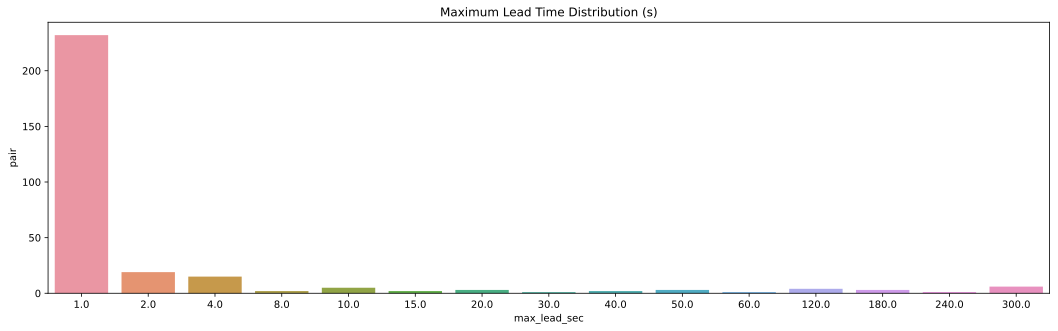

In [22]:
lead_group = result.groupby('max_lead_sec')
max_lead_df = lead_group.agg({'pair':'count'}).reset_index()
plt.figure(figsize=(18,5))
plt.title("Maximum Lead Time Distribution (s)")
sns.barplot(x='max_lead_sec', y='pair', data=max_lead_df)
# plt.savefig("./figures/bar1.png", dpi=800)

<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Minimum Lead Time Distribution (s)')

<AxesSubplot:title={'center':'Minimum Lead Time Distribution (s)'}, xlabel='min_lead_sec', ylabel='pair'>

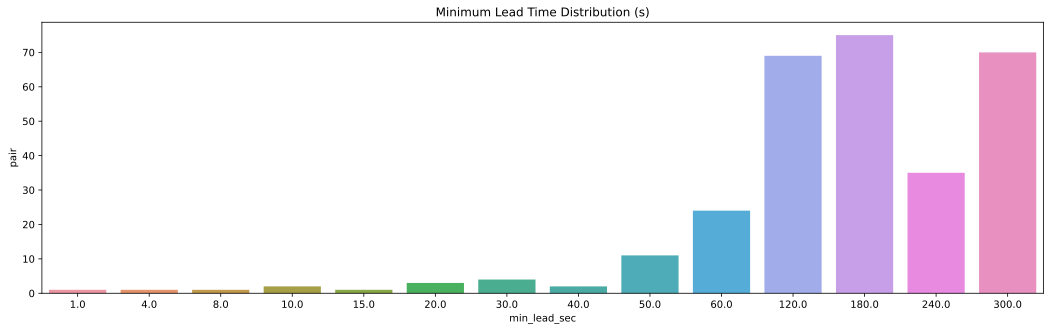

In [23]:
lead_group = result.groupby('min_lead_sec')
min_lead_df = lead_group.agg({'pair':'count'}).reset_index()
plt.figure(figsize=(18,5))
plt.title("Minimum Lead Time Distribution (s)")
sns.barplot(x='min_lead_sec', y='pair', data=min_lead_df)
# plt.savefig("./figures/bar1.png", dpi=800)

<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Maximum Lag Time Distribution (s)')

<AxesSubplot:title={'center':'Maximum Lag Time Distribution (s)'}, xlabel='max_lag_sec', ylabel='pair'>

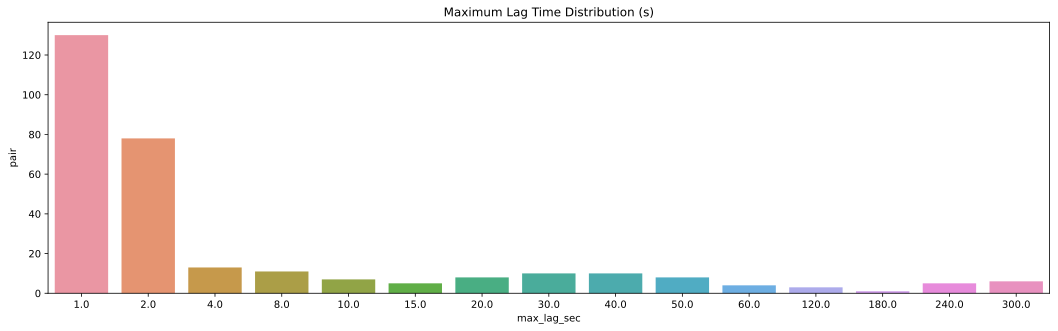

In [24]:
lag_group = result.groupby('max_lag_sec')
max_lag_df = lag_group.agg({'pair':'count'}).reset_index()
plt.figure(figsize=(18,5))
plt.title("Maximum Lag Time Distribution (s)")
sns.barplot(x='max_lag_sec', y='pair', data=max_lag_df)
# plt.savefig("./figures/bar2.png", dpi=800)

<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Minimum Lag Time Distribution (s)')

<AxesSubplot:title={'center':'Minimum Lag Time Distribution (s)'}, xlabel='min_lag_sec', ylabel='pair'>

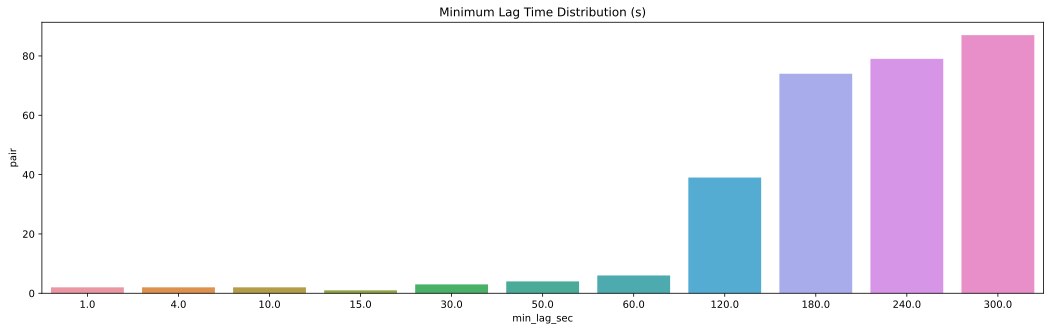

In [25]:
lead_group = result.groupby('min_lag_sec')
min_lag_df = lead_group.agg({'pair':'count'}).reset_index()
plt.figure(figsize=(18,5))
plt.title("Minimum Lag Time Distribution (s)")
sns.barplot(x='min_lag_sec', y='pair', data=min_lag_df)
# plt.savefig("./figures/bar1.png", dpi=800)

<Figure size 1296x432 with 0 Axes>

Text(0.5, 1.0, 'Maximum Lead/Lag Distribution')

<AxesSubplot:title={'center':'Maximum Lead/Lag Distribution'}, xlabel='seconds', ylabel='pair'>

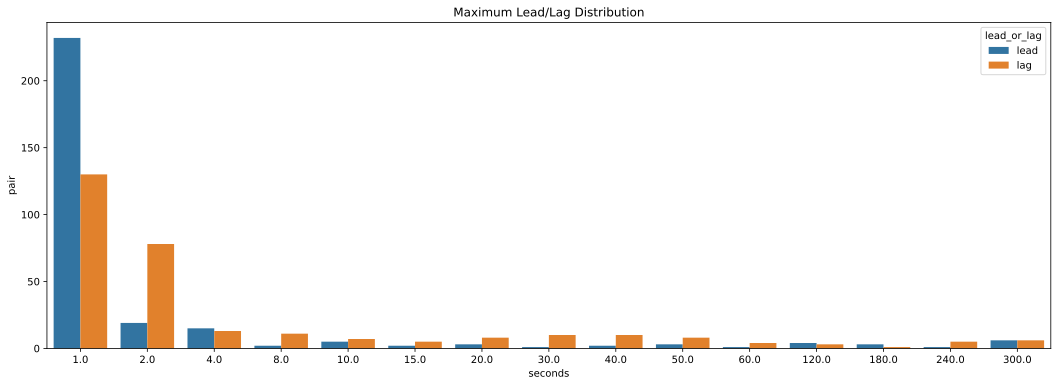

In [26]:
df1 = max_lead_df.rename(columns={'max_lead_sec': 'seconds'})
df1['lead_or_lag'] = 'lead'
df2 = max_lag_df.rename(columns={'max_lag_sec': 'seconds'})
df2['lead_or_lag'] = 'lag'
meg = pd.concat([df1, df2]).reset_index(drop=True)
plt.figure(figsize=(18,6))
plt.title("Maximum Lead/Lag Distribution")
sns.barplot(x='seconds', y='pair', hue='lead_or_lag', data=meg)
# plt.savefig("./figures/bar3.png", dpi=800)

<Figure size 1296x432 with 0 Axes>

Text(0.5, 1.0, 'Minimum Lead/Lag Distribution')

<AxesSubplot:title={'center':'Minimum Lead/Lag Distribution'}, xlabel='seconds', ylabel='pair'>

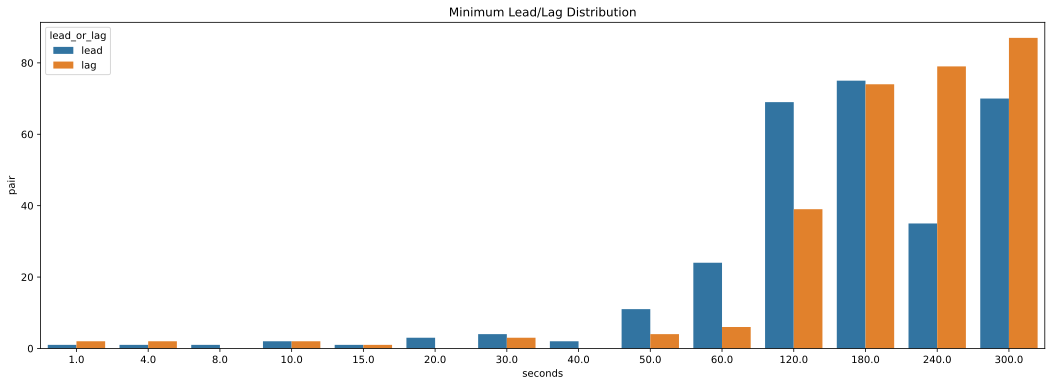

In [27]:
df1 = min_lead_df.rename(columns={'min_lead_sec': 'seconds'})
df1['lead_or_lag'] = 'lead'
df2 = min_lag_df.rename(columns={'min_lag_sec': 'seconds'})
df2['lead_or_lag'] = 'lag'
meg = pd.concat([df1, df2]).reset_index(drop=True)
plt.figure(figsize=(18,6))
plt.title("Minimum Lead/Lag Distribution")
sns.barplot(x='seconds', y='pair', hue='lead_or_lag', data=meg)
# plt.savefig("./figures/bar3.png", dpi=800)

<AxesSubplot:xlabel='llr', ylabel='Count'>

<AxesSubplot:xlabel='ori_corr', ylabel='Count'>

<AxesSubplot:xlabel='max_lead_corr', ylabel='Count'>

<AxesSubplot:xlabel='max_lag_corr', ylabel='Count'>

<AxesSubplot:xlabel='min_lead_corr', ylabel='Count'>

<AxesSubplot:xlabel='min_lag_corr', ylabel='Count'>

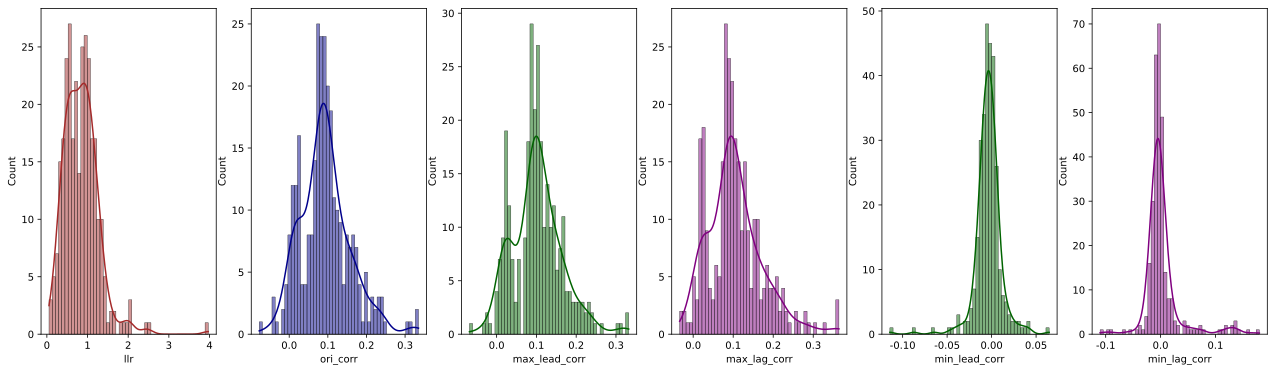

In [28]:
fig, axes = plt.subplots(1, 6, figsize=(22,6))
sns.histplot(result['llr'], bins=50, kde=True, color='brown', label='llr', ax=axes[0], legend=True)
sns.histplot(result['ori_corr'], bins=50, kde=True, color='darkblue', label='ori_corr', ax=axes[1], legend=True)
sns.histplot(result['max_lead_corr'], bins=50, kde=True, color='darkgreen', label='max_lag_corr', ax=axes[2], legend=True)
sns.histplot(result['max_lag_corr'], bins=50, kde=True, color='purple', label='max_lag_corr', ax=axes[3], legend=True)
sns.histplot(result['min_lead_corr'], bins=50, kde=True, color='darkgreen', label='min_lead_corr', ax=axes[4], legend=True)
sns.histplot(result['min_lag_corr'], bins=50, kde=True, color='purple', label='min_lag_corr', ax=axes[5], legend=True)
# plt.savefig("./figures/dist1.png", dpi=800)

In [29]:
result['llr'].skew()
result['llr'].kurtosis()

1.8831560505431264

9.658081787270854

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

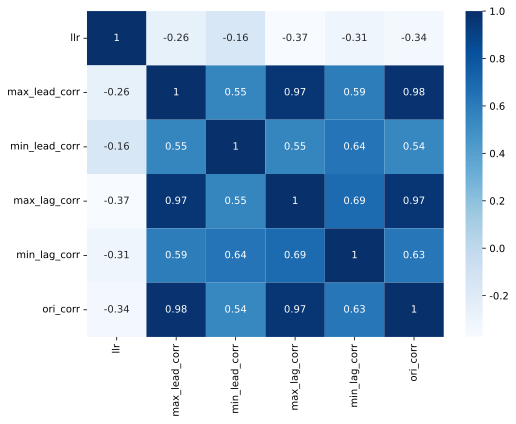

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(result[['llr','max_lead_corr','min_lead_corr','max_lag_corr', 'min_lag_corr', 'ori_corr']].corr(), annot=True, annot_kws={"size": 10}, cmap='Blues')
# plt.savefig("./figures/heat1.png", dpi=800)

In [31]:
result.head()

,pair,llr,max_lead_corr,max_lag_corr,min_lead_corr,min_lag_corr,ori_corr,asset1,asset2,max_lead_sec,max_lag_sec,min_lead_sec,min_lag_sec
0,"(000776,000166)",0.322835,0.250279,0.307090,0.015974,0.069427,0.242427,000776,000166,1.0,20.0,300.0,300.0
1,"(000776,000725)",0.532163,0.332037,0.358244,0.042655,0.118070,0.334727,000776,000725,1.0,20.0,300.0,300.0
2,"(000776,000157)",0.737268,0.205262,0.203955,0.003750,0.008223,0.187492,000776,000157,1.0,1.0,180.0,300.0
3,"(000776,000425)",0.536392,0.172015,0.178003,-0.000863,0.022372,0.160901,000776,000425,1.0,4.0,300.0,300.0
4,"(000776,002024)",0.130475,0.023151,0.003974,-0.035933,-0.110175,0.023405,000776,002024,1.0,1.0,240.0,300.0


In [ ]:
pair1 = sns.pairplot(result, vars=['llr','max_lead_corr', 'min_lead_corr','max_lag_corr', 'min_lag_corr', 'ori_corr'], height=1.5)
# pair1.savefig("./figures/pair1.png", dpi=500)

In [ ]:
pair2 = sns.pairplot(result, vars=['llr','max_lead_corr','max_lag_corr', 'ori_corr'], kind='scatter', diag_kind='kde',height=1.5)
pair2.map_lower(sns.kdeplot, levels=4, color=".2")
# pair2.savefig("./figures/pair2.png", dpi=500)

In [ ]:
pair3 = sns.pairplot(result, vars=['llr','max_lead_corr','max_lag_corr', 'ori_corr'], kind='hist', height=1.5, diag_kind='hist')
# pair3.savefig("./figures/pair3.png", dpi=500)

In [ ]:
pair4 = sns.pairplot(meg, hue='lead_or_lag', palette='flare')
# pair4.savefig("./figures/pair4.png", dpi=500)

In [33]:
result['llr_hat'] = np.where(result['llr'] < 1, 1/result['llr'], result['llr'])
result['ori_corr_hat'] = np.abs(result['ori_corr'])
result['lead_corr_hat'] = np.maximum(result['max_lead_corr'], np.abs(result['min_lead_corr']))
result['lag_corr_hat'] = np.maximum(result['max_lag_corr'], np.abs(result['min_lag_corr']))
result.head()

,pair,llr,max_lead_corr,max_lag_corr,min_lead_corr,min_lag_corr,ori_corr,asset1,asset2,max_lead_sec,max_lag_sec,min_lead_sec,min_lag_sec,llr_hat,ori_corr_hat,lead_corr_hat,lag_corr_hat
0,"(000776,000166)",0.322835,0.250279,0.307090,0.015974,0.069427,0.242427,000776,000166,1.0,20.0,300.0,300.0,3.097558,0.242427,0.250279,0.307090
1,"(000776,000725)",0.532163,0.332037,0.358244,0.042655,0.118070,0.334727,000776,000725,1.0,20.0,300.0,300.0,1.879125,0.334727,0.332037,0.358244
2,"(000776,000157)",0.737268,0.205262,0.203955,0.003750,0.008223,0.187492,000776,000157,1.0,1.0,180.0,300.0,1.356359,0.187492,0.205262,0.203955
3,"(000776,000425)",0.536392,0.172015,0.178003,-0.000863,0.022372,0.160901,000776,000425,1.0,4.0,300.0,300.0,1.864309,0.160901,0.172015,0.178003
4,"(000776,002024)",0.130475,0.023151,0.003974,-0.035933,-0.110175,0.023405,000776,002024,1.0,1.0,240.0,300.0,7.664332,0.023405,0.035933,0.110175


In [29]:
result.sort_values(['ori_corr_hat','llr_hat'], ascending=[False,False]).head(10)

,pair,llr,lead_time,max_lead_corr,lag_time,max_lag_corr,ori_corr,asset1,asset2,lead_sec,lag_sec,llr_hat,ori_corr_hat
194,"(000776,601162)",0.712970,0 days 00:00:01,0.088440,0 days 00:00:10,0.096361,0.088888,000776,601162,1.0,10.0,1.402584,0.088888
0,"(000776,000725)",0.748336,0 days 00:00:01,0.086499,0 days 00:00:01,0.092644,0.087247,000776,000725,1.0,1.0,1.336298,0.087247
20,"(000776,000001)",2.008671,0 days 00:00:04,0.092797,0 days 00:00:01,0.081390,0.087230,000776,000001,4.0,1.0,2.008671,0.087230
16,"(000776,000100)",1.613839,0 days 00:00:03,0.078715,0 days 00:00:01,0.073954,0.078262,000776,000100,3.0,1.0,1.613839,0.078262
105,"(000776,600010)",0.756638,0 days 00:00:01,0.076567,0 days 00:00:10,0.085850,0.077866,000776,600010,1.0,10.0,1.321636,0.077866
1,"(000776,000166)",0.682556,0 days 00:00:01,0.078766,0 days 00:00:07,0.083270,0.076472,000776,000166,1.0,7.0,1.465080,0.076472
241,"(000776,601868)",0.958135,0 days 00:00:01,0.075690,0 days 00:00:05,0.075410,0.075174,000776,601868,1.0,5.0,1.043694,0.075174
4,"(000776,000783)",0.626555,0 days 00:00:01,0.078740,0 days 00:00:06,0.095201,0.074672,000776,000783,1.0,6.0,1.596029,0.074672
21,"(000776,000063)",1.709945,0 days 00:00:03,0.073502,0 days 00:00:01,0.067797,0.072120,000776,000063,3.0,1.0,1.709945,0.072120
19,"(000776,000066)",2.029836,0 days 00:00:04,0.073858,0 days 00:00:01,0.062571,0.066928,000776,000066,4.0,1.0,2.029836,0.066928


In [34]:
result['rank_llr'] = result['llr_hat'].rank()
result['rank_ori_cor'] = result['ori_corr_hat'].rank()
result['rank_lead_cor'] = result['lead_corr_hat'].rank()
result['rank_lag_cor'] = result['lag_corr_hat'].rank()

result['rank_total'] = np.where(result['llr'] > 1,result['rank_llr'] + result['rank_ori_cor'] + result['rank_lead_cor'], result['rank_llr'] + result['rank_ori_cor'] + result['rank_lag_cor'])
result['rank_total'] = result['rank_total'].rank()
result.sort_values(by=['rank_total'], ascending=False).head(10)

,pair,llr,max_lead_corr,max_lag_corr,min_lead_corr,min_lag_corr,ori_corr,asset1,asset2,max_lead_sec,max_lag_sec,min_lead_sec,min_lag_sec,llr_hat,ori_corr_hat,lead_corr_hat,lag_corr_hat,rank_llr,rank_ori_cor,rank_lead_cor,rank_lag_cor,rank_total
0,"(000776,000166)",0.322835,0.250279,0.307090,0.015974,0.069427,0.242427,000776,000166,1.0,20.0,300.0,300.0,3.097558,0.242427,0.250279,0.307090,279.0,293.0,294.0,295.0,299.0
193,"(000776,601162)",0.421973,0.315304,0.364176,0.022359,0.111247,0.317797,000776,601162,1.0,30.0,300.0,300.0,2.369821,0.317797,0.315304,0.364176,253.0,297.0,297.0,299.0,298.0
206,"(000776,601319)",0.367130,0.214347,0.259714,0.000473,0.055216,0.216436,000776,601319,1.0,50.0,300.0,300.0,2.723830,0.216436,0.214347,0.259714,268.0,286.0,286.0,290.0,297.0
119,"(000776,600050)",0.432595,0.233826,0.287504,0.031172,0.136151,0.235189,000776,600050,1.0,50.0,300.0,300.0,2.311629,0.235189,0.233826,0.287504,252.0,291.0,291.0,294.0,296.0
241,"(000776,601868)",0.449177,0.238787,0.278041,0.011712,0.161806,0.242443,000776,601868,1.0,40.0,240.0,300.0,2.226295,0.242443,0.238787,0.278041,249.0,294.0,292.0,292.0,295.0
5,"(000776,000783)",0.478267,0.265390,0.280674,0.009972,0.019196,0.246750,000776,000783,1.0,4.0,180.0,300.0,2.090881,0.246750,0.265390,0.280674,242.0,295.0,295.0,293.0,294.0
101,"(000776,600010)",0.504319,0.324680,0.363135,0.001757,0.133959,0.330647,000776,600010,1.0,30.0,180.0,300.0,1.982873,0.330647,0.324680,0.363135,229.0,298.0,298.0,298.0,293.0
103,"(000776,600016)",0.352901,0.170789,0.224154,0.026847,0.129761,0.173750,000776,600016,1.0,30.0,300.0,240.0,2.833658,0.173750,0.170789,0.224154,271.0,269.0,265.0,284.0,292.0
112,"(000776,600028)",0.377212,0.169023,0.230010,0.025346,0.107896,0.175422,000776,600028,1.0,30.0,300.0,300.0,2.651031,0.175422,0.169023,0.230010,266.0,270.0,263.0,286.0,291.0
227,"(000776,601766)",0.351744,0.169371,0.209295,0.003756,0.046502,0.172945,000776,601766,1.0,50.0,300.0,240.0,2.842977,0.172945,0.169371,0.209295,273.0,268.0,264.0,278.0,290.0


In [35]:
result.sort_values(by=['rank_total'], ascending=False).to_csv("./data/000776_2.csv", index=False)

In [36]:
a = pd.read_csv("./data/000776_2.csv")
a.head()

,asset1,asset2,llr,max_lead_sec,max_lead_corr,max_lag_sec,max_lag_corr,min_lead_sec,min_lead_corr,min_lag_sec,min_lag_corr,ori_corr,llr_hat,ori_corr_hat,lead_corr_hat,lag_corr_hat,rank_llr,rank_ori_cor,rank_lead_cor,rank_lag_cor,rank_total,名称
0,776,725,0.532163,1,0.332037,20,0.358244,300,0.042655,300,0.118070,0.334727,1.879125,0.334727,0.332037,0.358244,219,299,299,297,287.0,京东方Ａ
1,776,600010,0.504319,1,0.324680,30,0.363135,180,0.001757,300,0.133959,0.330647,1.982873,0.330647,0.324680,0.363135,229,298,298,298,293.0,包钢股份
2,776,601162,0.421973,1,0.315304,30,0.364176,300,0.022359,300,0.111247,0.317797,2.369821,0.317797,0.315304,0.364176,253,297,297,299,298.0,天风证券
3,776,601728,0.639947,1,0.303881,40,0.325522,300,0.031038,300,0.180083,0.305456,1.562630,0.305456,0.303881,0.325522,186,296,296,296,277.0,XD中国电
4,776,783,0.478267,1,0.265390,4,0.280674,180,0.009972,300,0.019196,0.246750,2.090881,0.246750,0.265390,0.280674,242,295,295,293,294.0,长江证券


In [45]:
a[a['名称'].str.contains('证券')][['名称', 'llr','rank_llr','rank_ori_cor', 'max_lead_sec', 'rank_lead_cor', 'max_lag_sec','rank_lag_cor', 'rank_total']].sort_values(by=['rank_total'], ascending=False)

,名称,llr,rank_llr,rank_ori_cor,max_lead_sec,rank_lead_cor,max_lag_sec,rank_lag_cor,rank_total
2,天风证券,0.421973,253,297,1,297,30,299,298.0
4,长江证券,0.478267,242,295,1,295,4,293,294.0
20,海通证券,0.418322,255,279,1,276,8,279,286.0
15,方正证券,0.515688,224,284,1,285,2,281,280.0
11,兴业证券,0.573995,207,288,1,288,8,282,276.0
32,财通证券,0.508012,227,267,1,262,8,257,266.0
23,中泰证券,0.584350,200,276,1,274,1,267,262.5
18,国金证券,0.655305,177,281,1,279,2,274,259.5
33,国信证券,0.651757,182,266,1,282,1,277,258.0
21,华泰证券,0.666650,176,278,1,275,2,269,257.0


In [46]:
a[a['名称'].str.contains('证券')][['名称', 'llr','rank_llr','rank_ori_cor', 'max_lead_sec', 'rank_lead_cor', 'max_lag_sec','rank_lag_cor', 'rank_total']].sort_values(by=['rank_llr'], ascending=False)

,名称,llr,rank_llr,rank_ori_cor,max_lead_sec,rank_lead_cor,max_lag_sec,rank_lag_cor,rank_total
20,海通证券,0.418322,255,279,1,276,8,279,286.0
2,天风证券,0.421973,253,297,1,297,30,299,298.0
4,长江证券,0.478267,242,295,1,295,4,293,294.0
32,财通证券,0.508012,227,267,1,262,8,257,266.0
15,方正证券,0.515688,224,284,1,285,2,281,280.0
284,中银证券,1.890486,220,4,40,24,30,6,48.0
11,兴业证券,0.573995,207,288,1,288,8,282,276.0
23,中泰证券,0.584350,200,276,1,274,1,267,262.5
42,招商证券,0.589032,198,257,1,253,2,247,251.0
33,国信证券,0.651757,182,266,1,282,1,277,258.0


In [47]:
a[a['名称'].str.contains('证券')][['名称', 'llr','rank_llr','rank_ori_cor', 'max_lead_sec', 'rank_lead_cor', 'max_lag_sec','rank_lag_cor', 'rank_total']].sort_values(by=['rank_ori_cor'], ascending=False)

,名称,llr,rank_llr,rank_ori_cor,max_lead_sec,rank_lead_cor,max_lag_sec,rank_lag_cor,rank_total
2,天风证券,0.421973,253,297,1,297,30,299,298.0
4,长江证券,0.478267,242,295,1,295,4,293,294.0
11,兴业证券,0.573995,207,288,1,288,8,282,276.0
15,方正证券,0.515688,224,284,1,285,2,281,280.0
16,浙商证券,0.774675,129,283,1,280,2,276,248.0
18,国金证券,0.655305,177,281,1,279,2,274,259.5
20,海通证券,0.418322,255,279,1,276,8,279,286.0
21,华泰证券,0.666650,176,278,1,275,2,269,257.0
23,中泰证券,0.584350,200,276,1,274,1,267,262.5
25,中信证券,0.653357,179,274,1,271,2,259,253.0


In [48]:
a[a['名称'].str.contains('证券')][['名称', 'llr','rank_llr','rank_ori_cor', 'max_lead_sec', 'rank_lead_cor', 'max_lag_sec','rank_lag_cor', 'rank_total']].sort_values(by=['rank_lead_cor'], ascending=False)

,名称,llr,rank_llr,rank_ori_cor,max_lead_sec,rank_lead_cor,max_lag_sec,rank_lag_cor,rank_total
2,天风证券,0.421973,253,297,1,297,30,299,298.0
4,长江证券,0.478267,242,295,1,295,4,293,294.0
11,兴业证券,0.573995,207,288,1,288,8,282,276.0
15,方正证券,0.515688,224,284,1,285,2,281,280.0
33,国信证券,0.651757,182,266,1,282,1,277,258.0
16,浙商证券,0.774675,129,283,1,280,2,276,248.0
18,国金证券,0.655305,177,281,1,279,2,274,259.5
20,海通证券,0.418322,255,279,1,276,8,279,286.0
21,华泰证券,0.666650,176,278,1,275,2,269,257.0
23,中泰证券,0.584350,200,276,1,274,1,267,262.5


In [49]:
a[a['名称'].str.contains('证券')][['名称', 'llr','rank_llr','rank_ori_cor', 'max_lead_sec', 'rank_lead_cor', 'max_lag_sec','rank_lag_cor', 'rank_total']].sort_values(by=['rank_lag_cor'], ascending=False)

,名称,llr,rank_llr,rank_ori_cor,max_lead_sec,rank_lead_cor,max_lag_sec,rank_lag_cor,rank_total
2,天风证券,0.421973,253,297,1,297,30,299,298.0
4,长江证券,0.478267,242,295,1,295,4,293,294.0
11,兴业证券,0.573995,207,288,1,288,8,282,276.0
15,方正证券,0.515688,224,284,1,285,2,281,280.0
20,海通证券,0.418322,255,279,1,276,8,279,286.0
33,国信证券,0.651757,182,266,1,282,1,277,258.0
16,浙商证券,0.774675,129,283,1,280,2,276,248.0
18,国金证券,0.655305,177,281,1,279,2,274,259.5
21,华泰证券,0.666650,176,278,1,275,2,269,257.0
23,中泰证券,0.584350,200,276,1,274,1,267,262.5


**EDA for the saved file**

In [3]:
nums = [1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300]
grid = [timedelta(seconds=i) for i in nums]

In [14]:
with open("./data/result_000776_notick_new.pkl", "rb") as tf:
    summary = pickle.load(tf)
summary

OrderedDict([(('000776', '000001'),
              OrderedDict([('max_lead', datetime.timedelta(seconds=4)),
                           ('max_lead_corr', 0.39994475116217143),
                           ('min_lead', datetime.timedelta(seconds=300)),
                           ('min_lead_corr', 0.24900366366590324),
                           ('max_lag', datetime.timedelta(seconds=1)),
                           ('max_lag_corr', 0.39992078145355675),
                           ('min_lag', datetime.timedelta(seconds=300)),
                           ('min_lag_corr', 0.2187414971062488),
                           ('ori_corr', 0.39449114435912463),
                           ('hy_corr',
                            array([0.2187415 , 0.2437704 , 0.25119301, 0.26287455, 0.26127092,
                                   0.28157549, 0.28839674, 0.27343563, 0.29501582, 0.29352148,
                                   0.30505347, 0.31680635, 0.35514241, 0.38954658, 0.39992078,
                       

In [15]:
gf_result = pd.DataFrame(summary).T.reset_index()
gf_result.rename(columns={"level_0": 'asset1', "level_1": "asset2"}, inplace=True)
gf_result['max_lead'] = gf_result['max_lead'].dt.microseconds/1000000 + gf_result['max_lead'].dt.seconds
gf_result['min_lead'] = gf_result['min_lead'].dt.microseconds/1000000 + gf_result['min_lead'].dt.seconds
gf_result['max_lag'] = gf_result['max_lag'].dt.microseconds/1000000 + gf_result['max_lag'].dt.seconds
gf_result['min_lag'] = gf_result['min_lag'].dt.microseconds/1000000 + gf_result['min_lag'].dt.seconds

In [16]:
hushen300 = pd.read_csv("./data/hushen300.csv")
gf_result['name'] = hushen300['名称']
gf_result = gf_result[gf_result['name']!='广发证券']
temp = gf_result.loc[gf_result['LLR'] < 1, ]
temp.drop(['max_lead', 'max_lead_corr', 'min_lead', 'min_lead_corr', 'min_lag', 'min_lag_corr'], axis=1, inplace=True)

In [17]:
temp2 = temp.copy()
temp2['mean_lag_corr'] = temp2['hy_corr'].apply(lambda x: x[:nums.__len__()].mean())
temp2['llr_rank'] = temp2['LLR'].rank(ascending=True)
temp2['ori_corr_rank'] = temp2['ori_corr'].rank(ascending=False)
temp2['maxlag_corr_rank'] = temp2['max_lag_corr'].rank(ascending=False)
temp2['meanlag_corr_rank'] = temp2['mean_lag_corr'].rank(ascending=False)
temp2['total_rank'] = (temp2['ori_corr_rank']*2 + temp2['maxlag_corr_rank'] + temp2['meanlag_corr_rank']).rank(ascending=True)

In [18]:
temp2.sort_values('total_rank', ascending=True).head(20)

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
2,000776,000063,1.0,0.345719,0.343263,"[0.20583765068089824, 0.22446705611955975, 0.2...",0.890445,中兴通讯,0.259681,65.0,1.0,1.0,1.0,1.0
5,000776,000100,1.0,0.336826,0.332436,"[0.1817514669760952, 0.19916133702444247, 0.20...",0.905501,TCL科技,0.243152,70.0,2.0,2.0,3.0,2.0
3,000776,000066,1.0,0.321845,0.316272,"[0.2175269089738715, 0.2372760180406536, 0.238...",0.94535,中国长城,0.257787,82.0,3.0,3.0,2.0,3.0
261,000776,601995,2.0,0.292166,0.298824,"[0.16530990417291916, 0.18733491931957835, 0.2...",0.974266,中金公司,0.236017,96.0,4.0,4.0,4.0,4.0
194,000776,601066,2.0,0.282703,0.285841,"[0.1682160408663751, 0.1731935046849584, 0.189...",0.908986,中信建投,0.220773,73.0,5.0,5.0,6.0,5.0
127,000776,600030,2.0,0.270909,0.269857,"[0.15210244177141602, 0.16136565013081136, 0.1...",0.841318,中信证券,0.203868,54.0,6.0,6.0,10.0,6.0
189,000776,600999,2.0,0.253469,0.265111,"[0.17552155365597555, 0.21118801326974151, 0.2...",0.955782,招商证券,0.216526,91.0,7.0,9.0,7.0,7.0
235,000776,601788,2.0,0.250346,0.260138,"[0.17282160939801133, 0.1780928958211792, 0.18...",0.950479,光大证券,0.206316,86.0,8.0,11.0,9.0,8.0
260,000776,601990,2.0,0.252056,0.250975,"[0.16139293903497864, 0.1581819608835817, 0.18...",0.895504,南京证券,0.200615,68.0,9.0,10.0,11.0,9.0
108,000776,300750,1.0,0.265555,0.238986,"[0.2049705964395837, 0.22826534889329994, 0.23...",0.891319,宁德时代,0.224948,66.0,14.0,7.0,5.0,10.0


In [8]:
# code2 = '601162'
# plot_corr('000776', code2, nums=nums, result=summary[('000776', code2)])

In [19]:
temp2[temp2['name'].str.contains("证券") | temp2['name'].str.contains("申万") | temp2['name'].isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富'])].sort_values(['total_rank'])

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
261,000776,601995,2.0,0.292166,0.298824,"[0.16530990417291916, 0.18733491931957835, 0.2...",0.974266,中金公司,0.236017,96.0,4.0,4.0,4.0,4.0
194,000776,601066,2.0,0.282703,0.285841,"[0.1682160408663751, 0.1731935046849584, 0.189...",0.908986,中信建投,0.220773,73.0,5.0,5.0,6.0,5.0
127,000776,600030,2.0,0.270909,0.269857,"[0.15210244177141602, 0.16136565013081136, 0.1...",0.841318,中信证券,0.203868,54.0,6.0,6.0,10.0,6.0
189,000776,600999,2.0,0.253469,0.265111,"[0.17552155365597555, 0.21118801326974151, 0.2...",0.955782,招商证券,0.216526,91.0,7.0,9.0,7.0,7.0
235,000776,601788,2.0,0.250346,0.260138,"[0.17282160939801133, 0.1780928958211792, 0.18...",0.950479,光大证券,0.206316,86.0,8.0,11.0,9.0,8.0
260,000776,601990,2.0,0.252056,0.250975,"[0.16139293903497864, 0.1581819608835817, 0.18...",0.895504,南京证券,0.200615,68.0,9.0,10.0,11.0,9.0
205,000776,601211,1.0,0.244728,0.245917,"[0.14138483092954068, 0.159057951630123, 0.167...",0.843194,国泰君安,0.193216,56.0,11.0,13.0,13.0,12.0
230,000776,601688,2.0,0.234987,0.246747,"[0.13319961910517486, 0.14305982902656228, 0.1...",0.986579,华泰证券,0.181580,101.0,10.0,16.0,18.0,14.0
76,000776,002736,1.0,0.237894,0.214072,"[0.15399582527313907, 0.17244411850093339, 0.1...",0.989581,国信证券,0.195881,105.0,17.0,14.0,12.0,15.0
247,000776,601881,2.0,0.207416,0.213993,"[0.11615983781687575, 0.13060866365067922, 0.1...",0.895169,中国银河,0.161451,67.0,18.0,26.0,27.0,22.0


In [20]:
temp3 = gf_result.loc[gf_result['LLR'] > 1, ]
temp3.drop(['max_lag', 'max_lag_corr', 'min_lag', 'min_lag_corr', 'min_lead', 'min_lead_corr'], axis=1, inplace=True)

temp4 = temp3.copy()
temp4['mean_lead_corr'] = temp4['hy_corr'].apply(lambda x: x[nums.__len__()+1:].mean())
temp4['ori_corr_rank'] = temp4['ori_corr'].rank(ascending=False)
temp4['maxlead_corr_rank'] = temp4['max_lead_corr'].rank(ascending=False)
temp4['meanlead_corr_rank'] = temp4['mean_lead_corr'].rank(ascending=False)
temp4['total_rank'] = (temp4['ori_corr_rank']*2 + temp4['maxlead_corr_rank'] + temp4['meanlead_corr_rank']).rank(ascending=True)

In [21]:
temp4.sort_values('total_rank', ascending=True).head(20)

,asset1,asset2,max_lead,max_lead_corr,ori_corr,hy_corr,LLR,name,mean_lead_corr,ori_corr_rank,maxlead_corr_rank,meanlead_corr_rank,total_rank
0,000776,000001,4.0,0.399945,0.394491,"[0.2187414971062488, 0.24377040224315805, 0.25...",1.087583,平安银行,0.308136,1.0,1.0,1.0,1.0
87,000776,300033,300.0,0.329954,0.282886,"[0.19370561723531154, 0.21138462122161816, 0.2...",1.366222,同花顺,0.290263,2.0,3.0,2.0,2.0
67,000776,002568,240.0,0.355613,0.268609,"[0.26409836691298266, 0.26630278014823316, 0.2...",1.391869,百润股份,0.287981,5.0,2.0,3.0,3.0
146,000776,600276,300.0,0.308835,0.271907,"[0.250009797778341, 0.2626040727641072, 0.2646...",1.258134,恒瑞医药,0.276179,4.0,4.0,4.0,4.0
216,000776,601336,1.0,0.283025,0.276955,"[0.22418300671431665, 0.25370787017468405, 0.2...",1.043904,新华保险,0.243889,3.0,7.0,6.0,5.0
187,000776,600958,60.0,0.268098,0.268258,"[0.27143979940562757, 0.25333910562220124, 0.2...",1.050624,东方证券,0.255449,6.0,10.0,5.0,6.0
246,000776,601878,4.0,0.272014,0.252669,"[0.13341805503196943, 0.1483037998246002, 0.16...",1.434219,浙商证券,0.227724,7.0,9.0,9.0,7.0
54,000776,002304,1.0,0.258057,0.245168,"[0.1122407059193485, 0.12894120802405257, 0.12...",1.341699,洋河股份,0.231346,8.0,12.0,8.0,8.0
68,000776,002594,1.0,0.275489,0.244755,"[0.14795234578070646, 0.164160575960915, 0.187...",1.065204,比亚迪,0.215202,9.0,8.0,14.0,9.0
271,000776,603338,180.0,0.2857,0.229552,"[0.1328822631197095, 0.13966962241802333, 0.14...",1.351104,浙江鼎力,0.216144,15.0,6.0,12.0,10.0


In [22]:
temp4[temp4['name'].str.contains("证券") | temp4['name'].str.contains("申万") | temp4['name'].isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富'])].sort_values(['total_rank'])

,asset1,asset2,max_lead,max_lead_corr,ori_corr,hy_corr,LLR,name,mean_lead_corr,ori_corr_rank,maxlead_corr_rank,meanlead_corr_rank,total_rank
87,000776,300033,300.0,0.329954,0.282886,"[0.19370561723531154, 0.21138462122161816, 0.2...",1.366222,同花顺,0.290263,2.0,3.0,2.0,2.0
187,000776,600958,60.0,0.268098,0.268258,"[0.27143979940562757, 0.25333910562220124, 0.2...",1.050624,东方证券,0.255449,6.0,10.0,5.0,6.0
246,000776,601878,4.0,0.272014,0.252669,"[0.13341805503196943, 0.1483037998246002, 0.16...",1.434219,浙商证券,0.227724,7.0,9.0,9.0,7.0
210,000776,601236,1.0,0.239646,0.234633,"[0.1430459033651554, 0.13317030272622787, 0.16...",1.308615,红塔证券,0.215513,10.0,18.0,13.0,11.0
218,000776,601377,1.0,0.241096,0.231864,"[0.10908956426740722, 0.10607751985131633, 0.1...",1.22107,兴业证券,0.179683,12.0,16.0,29.0,15.0
175,000776,600837,1.0,0.223303,0.229946,"[0.13321954111331508, 0.13345307497445827, 0.1...",1.095705,海通证券,0.184677,14.0,26.0,26.0,20.5
197,000776,601108,1.0,0.221566,0.221752,"[0.11637382102805184, 0.1460314080620834, 0.15...",1.0976,财通证券,0.172348,17.0,29.0,34.0,23.0
23,000776,000783,1.0,0.234111,0.198705,"[0.11364115589734736, 0.1240443830653465, 0.13...",1.241692,长江证券,0.188151,32.0,21.0,24.0,26.0
136,000776,600109,1.0,0.228234,0.204931,"[0.11717328244783547, 0.11165886964778232, 0.1...",1.10131,国金证券,0.159986,25.0,24.0,46.0,28.0
251,000776,601901,2.0,0.199723,0.18388,"[0.09735831217109454, 0.0952341363716444, 0.11...",1.390021,方正证券,0.155211,45.0,46.0,50.0,43.0


In [23]:
final = pd.concat([temp2[['asset1', 'asset2', 'LLR', 'ori_corr', 'ori_corr_rank', 'total_rank', 'name']], temp4[['asset1', 'asset2', 'LLR', 'ori_corr', 'ori_corr_rank', 'total_rank', 'name']]])
# final['total_rank'] = final['total_rank'].rank(ascending=True)
final.sort_values('total_rank', ascending=True).head(20)

,asset1,asset2,LLR,ori_corr,ori_corr_rank,total_rank,name
2,000776,000063,0.890445,0.343263,1.0,1.0,中兴通讯
0,000776,000001,1.087583,0.394491,1.0,1.0,平安银行
5,000776,000100,0.905501,0.332436,2.0,2.0,TCL科技
87,000776,300033,1.366222,0.282886,2.0,2.0,同花顺
67,000776,002568,1.391869,0.268609,5.0,3.0,百润股份
3,000776,000066,0.94535,0.316272,3.0,3.0,中国长城
146,000776,600276,1.258134,0.271907,4.0,4.0,恒瑞医药
261,000776,601995,0.974266,0.298824,4.0,4.0,中金公司
216,000776,601336,1.043904,0.276955,3.0,5.0,新华保险
194,000776,601066,0.908986,0.285841,5.0,5.0,中信建投


In [24]:
final[final['name'].str.contains("证券") | final['name'].str.contains("申万") | final['name'].isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富'])].sort_values(['total_rank'])

,asset1,asset2,LLR,ori_corr,ori_corr_rank,total_rank,name
87,000776,300033,1.366222,0.282886,2.0,2.0,同花顺
261,000776,601995,0.974266,0.298824,4.0,4.0,中金公司
194,000776,601066,0.908986,0.285841,5.0,5.0,中信建投
127,000776,600030,0.841318,0.269857,6.0,6.0,中信证券
187,000776,600958,1.050624,0.268258,6.0,6.0,东方证券
189,000776,600999,0.955782,0.265111,7.0,7.0,招商证券
246,000776,601878,1.434219,0.252669,7.0,7.0,浙商证券
235,000776,601788,0.950479,0.260138,8.0,8.0,光大证券
260,000776,601990,0.895504,0.250975,9.0,9.0,南京证券
210,000776,601236,1.308615,0.234633,10.0,11.0,红塔证券


In [103]:
# temp2.to_csv("./data/000776_lag.csv", index=False, encoding='gbk')
# temp4.to_csv("./data/000776_lead.csv", index=False, encoding='gbk')
# final.to_csv("./data/000776_total.csv", index=False, encoding='gbk')

Simple trial checking whether the correlation are correct

In [2]:
begin = '2022-04-06'
end = '2022-04-29'

import tushare as ts
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api()
# df = pro.trade_cal(exchange='', start_date=begin, end_date=end, fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
df = ts.get_k_data('sh', start=begin, end=end)

date_list = df['date'].str.replace('-', '').to_list()

date_list = ['20220412']

code_list2 = pd.read_csv("./data/hushen300.csv")
code_list2 = code_list2['代码'].apply(lambda x: "%06d"%x)
code_list2 = code_list2.tolist()

from itertools import product
import pickle
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
nums = [1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300]
grid = [timedelta(seconds=i) for i in nums]


code_list1 = ['000776']
code_list2 = code_list2

# trial = scan_all_pairs(all_pairs, date, grid)
trial = scan_all_pairs(code_list1, code_list2, date_list, grid)
trial

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
maximum lead correlation of pair (000776 vs 002049) (lead = 0:00:10): 0.057547042065901284
minimum lead correlation of pair (000776 vs 002049) (lead = 0:00:40): -0.07696092046953021
maximum lag correlation of pair (000776 vs 002049) (lag = 0:00:04): 0.1423568650742656
minimum lag correlation of pair (000776 vs 002049) (lag = 0:00:20): -0.06359000242766591
mean lead correlation of pair (000776 vs 002049): -0.0035377944186924513
mean lag correlation of pair (000776 vs 002049): 0.0012849973183135003
Original correlation of pair (000776 vs 002049): -0.031117772897421805
Lead/lag ratio of pair (000776 vs 002049): 0.6527050737608178
maximum lead correlation of pair (000776 vs 000100) (lead = 0:04:00): 0.01617970838502744
minimum lead correlation of pair (000776 vs 000100) (lead = 0:00:30): -0.07617003756879377
maximum lag correlation of pair (000776 vs 000100) (lag = 0:00:20): 0.049669854457880455
minimum lag correlation of pair (000776 vs

OrderedDict([(('000776', '000001'),
              OrderedDict([('max_lead', datetime.timedelta(seconds=240)),
                           ('max_lead_corr', 0.09014927860944259),
                           ('min_lead', datetime.timedelta(seconds=180)),
                           ('min_lead_corr', -0.009049010763927409),
                           ('max_lag', datetime.timedelta(seconds=30)),
                           ('max_lag_corr', 0.05444743764781018),
                           ('min_lag', datetime.timedelta(seconds=120)),
                           ('min_lag_corr', -0.03638349902288724),
                           ('ori_corr', 0.02372170053387807),
                           ('hy_corr',
                            array([ 0.04231392,  0.01695624,  0.00509539, -0.0363835 ,  0.00785611,
                                    0.01704145,  0.03577001,  0.05444744,  0.02436928,  0.053033  ,
                                    0.01971696,  0.01622346,  0.05098802,  0.0228185 ,  0.03115177,
 

In [3]:
with open("./data/trial_notick.pkl", "wb") as tf:
    pickle.dump(trial, tf)

In [104]:
with open("./data/trial_notick.pkl", "rb") as tf:
    trial = pickle.load(tf)

In [130]:
trial1 = pd.DataFrame(trial).T.reset_index()
trial1.rename(columns={"level_0": 'asset1', "level_1": "asset2"}, inplace=True)
trial1['max_lead'] = trial1['max_lead'].dt.microseconds/1000000 + trial1['max_lead'].dt.seconds
trial1['min_lead'] = trial1['min_lead'].dt.microseconds/1000000 + trial1['min_lead'].dt.seconds
trial1['max_lag'] = trial1['max_lag'].dt.microseconds/1000000 + trial1['max_lag'].dt.seconds
trial1['min_lag'] = trial1['min_lag'].dt.microseconds/1000000 + trial1['min_lag'].dt.seconds

hushen300 = pd.read_csv("./data/hushen300.csv")
trial1['name'] = hushen300['名称']

trial1 = trial1[trial1['name']!='广发证券']
trial2 = trial1.loc[trial1['LLR'] < 1, ]
trial2.drop(['max_lead', 'max_lead_corr', 'min_lead', 'min_lead_corr', 'min_lag', 'min_lag_corr'], axis=1, inplace=True)
trial2['mean_lag_corr'] = trial2['hy_corr'].apply(lambda x: x[:nums.__len__()].mean())
trial3 = trial2.copy()
trial3['llr_rank'] = trial3['LLR'].rank(ascending=True)
trial3['ori_corr_rank'] = trial3['ori_corr'].rank(ascending=False)
trial3['maxlag_corr_rank'] = trial3['max_lag_corr'].rank(ascending=False)
trial3['meanlag_corr_rank'] = trial3['mean_lag_corr'].rank(ascending=False)
trial3['total_rank'] = (trial3['ori_corr_rank']*2 + trial3['maxlag_corr_rank'] + trial3['meanlag_corr_rank']).rank(ascending=True)

In [131]:
trial3.sort_values('ori_corr_rank', ascending=True).head(20)

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
194,000776,601066,1.0,0.13283,0.140423,"[0.024812744137096762, -0.02168179850465789, 0...",0.596058,中信建投,0.039993,76.0,1.0,4.0,13.0,4.0
210,000776,601236,1.0,0.151351,0.126757,"[-0.013085598390009697, 0.03168922019749737, -...",0.873623,红塔证券,0.044081,147.0,2.0,1.0,8.0,1.0
261,000776,601995,1.0,0.124171,0.124245,"[0.040011603566884046, -0.020975890982449424, ...",0.473352,中金公司,0.057949,46.0,3.0,8.0,1.0,2.5
3,000776,000066,4.0,0.132459,0.119718,"[0.03103290379688238, -0.06916889446277388, -0...",0.601477,中国长城,0.051878,77.0,4.0,5.0,2.0,2.5
246,000776,601878,2.0,0.119295,0.105223,"[0.033741744446246134, -0.008955154924129525, ...",0.555145,浙商证券,0.045138,65.0,5.0,11.0,6.0,5.0
129,000776,600036,2.0,0.08471,0.104822,"[0.02114387764717764, -0.0007631548195350456, ...",0.679083,招商银行,0.029958,97.0,6.0,47.0,47.0,21.5
156,000776,600438,2.0,0.085405,0.103713,"[0.038523226927407506, -0.04683661198368232, 0...",0.561377,通威股份,0.026648,67.0,7.0,42.0,60.0,24.0
235,000776,601788,1.0,0.115117,0.101236,"[0.007535667929549047, -0.03153082107362337, -...",0.579822,光大证券,0.037387,72.0,8.0,12.0,19.0,7.0
216,000776,601336,1.0,0.11192,0.100749,"[0.03426662225965856, 0.013490796165218632, 0....",0.339117,新华保险,0.042599,10.0,9.0,14.0,10.0,6.0
226,000776,601633,2.0,0.102864,0.099563,"[-0.002788046883961777, -0.00836414065186563, ...",0.632856,长城汽车,0.031192,84.0,10.0,27.0,39.0,16.0


In [132]:
trial3.sort_values('total_rank', ascending=True).head(20)

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
210,000776,601236,1.0,0.151351,0.126757,"[-0.013085598390009697, 0.03168922019749737, -...",0.873623,红塔证券,0.044081,147.0,2.0,1.0,8.0,1.0
3,000776,000066,4.0,0.132459,0.119718,"[0.03103290379688238, -0.06916889446277388, -0...",0.601477,中国长城,0.051878,77.0,4.0,5.0,2.0,2.5
261,000776,601995,1.0,0.124171,0.124245,"[0.040011603566884046, -0.020975890982449424, ...",0.473352,中金公司,0.057949,46.0,3.0,8.0,1.0,2.5
194,000776,601066,1.0,0.13283,0.140423,"[0.024812744137096762, -0.02168179850465789, 0...",0.596058,中信建投,0.039993,76.0,1.0,4.0,13.0,4.0
246,000776,601878,2.0,0.119295,0.105223,"[0.033741744446246134, -0.008955154924129525, ...",0.555145,浙商证券,0.045138,65.0,5.0,11.0,6.0,5.0
216,000776,601336,1.0,0.11192,0.100749,"[0.03426662225965856, 0.013490796165218632, 0....",0.339117,新华保险,0.042599,10.0,9.0,14.0,10.0,6.0
235,000776,601788,1.0,0.115117,0.101236,"[0.007535667929549047, -0.03153082107362337, -...",0.579822,光大证券,0.037387,72.0,8.0,12.0,19.0,7.0
231,000776,601696,2.0,0.135823,0.072488,"[-0.015183926203867283, 0.014871927720230235, ...",0.511416,中银证券,0.041066,52.0,23.0,3.0,12.0,8.0
187,000776,600958,1.0,0.093465,0.098615,"[0.013903953452090046, -0.0011586627876774191,...",0.499314,东方证券,0.042630,49.0,11.0,36.0,9.0,9.0
70,000776,002601,1.0,0.127785,0.07439,"[-0.010144146152186107, 0.012031429157243931, ...",0.664399,龙佰集团,0.037389,90.0,22.0,7.0,18.0,10.0


In [133]:
trial3.sort_values('meanlag_corr_rank', ascending=True).head(20)

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
261,000776,601995,1.0,0.124171,0.124245,"[0.040011603566884046, -0.020975890982449424, ...",0.473352,中金公司,0.057949,46.0,3.0,8.0,1.0,2.5
3,000776,000066,4.0,0.132459,0.119718,"[0.03103290379688238, -0.06916889446277388, -0...",0.601477,中国长城,0.051878,77.0,4.0,5.0,2.0,2.5
2,000776,000063,40.0,0.068477,0.044998,"[0.045651357927697686, 0.060463766617056124, 0...",0.334261,中兴通讯,0.047671,9.0,68.0,83.0,3.0,51.0
16,000776,000651,1.0,0.129309,0.06767,"[0.022654770548088562, 0.011474494173708605, -...",0.501032,格力电器,0.046374,51.0,31.0,6.0,4.0,13.0
26,000776,000858,1.0,0.123832,0.047582,"[0.001512209519709051, -0.022839578263131412, ...",0.393055,五 粮 液,0.046202,25.0,65.0,9.0,5.0,31.0
246,000776,601878,2.0,0.119295,0.105223,"[0.033741744446246134, -0.008955154924129525, ...",0.555145,浙商证券,0.045138,65.0,5.0,11.0,6.0,5.0
127,000776,600030,1.0,0.096074,0.09582,"[0.006681190780204438, 0.00989492811752005, 0....",0.354661,中信证券,0.044389,14.0,14.0,35.0,7.0,11.5
210,000776,601236,1.0,0.151351,0.126757,"[-0.013085598390009697, 0.03168922019749737, -...",0.873623,红塔证券,0.044081,147.0,2.0,1.0,8.0,1.0
187,000776,600958,1.0,0.093465,0.098615,"[0.013903953452090046, -0.0011586627876774191,...",0.499314,东方证券,0.042630,49.0,11.0,36.0,9.0,9.0
216,000776,601336,1.0,0.11192,0.100749,"[0.03426662225965856, 0.013490796165218632, 0....",0.339117,新华保险,0.042599,10.0,9.0,14.0,10.0,6.0


In [134]:
trial3[trial3['name'].str.contains("证券") | trial3['name'].str.contains("申万") | trial3['name'].isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富'])].sort_values(['total_rank'])

,asset1,asset2,max_lag,max_lag_corr,ori_corr,hy_corr,LLR,name,mean_lag_corr,llr_rank,ori_corr_rank,maxlag_corr_rank,meanlag_corr_rank,total_rank
210,000776,601236,1.0,0.151351,0.126757,"[-0.013085598390009697, 0.03168922019749737, -...",0.873623,红塔证券,0.044081,147.0,2.0,1.0,8.0,1.0
261,000776,601995,1.0,0.124171,0.124245,"[0.040011603566884046, -0.020975890982449424, ...",0.473352,中金公司,0.057949,46.0,3.0,8.0,1.0,2.5
194,000776,601066,1.0,0.13283,0.140423,"[0.024812744137096762, -0.02168179850465789, 0...",0.596058,中信建投,0.039993,76.0,1.0,4.0,13.0,4.0
246,000776,601878,2.0,0.119295,0.105223,"[0.033741744446246134, -0.008955154924129525, ...",0.555145,浙商证券,0.045138,65.0,5.0,11.0,6.0,5.0
235,000776,601788,1.0,0.115117,0.101236,"[0.007535667929549047, -0.03153082107362337, -...",0.579822,光大证券,0.037387,72.0,8.0,12.0,19.0,7.0
231,000776,601696,2.0,0.135823,0.072488,"[-0.015183926203867283, 0.014871927720230235, ...",0.511416,中银证券,0.041066,52.0,23.0,3.0,12.0,8.0
187,000776,600958,1.0,0.093465,0.098615,"[0.013903953452090046, -0.0011586627876774191,...",0.499314,东方证券,0.042630,49.0,11.0,36.0,9.0,9.0
260,000776,601990,1.0,0.110055,0.098323,"[0.028863709267060257, -0.025511794642486013, ...",0.679957,南京证券,0.033519,98.0,12.0,19.0,27.0,11.5
127,000776,600030,1.0,0.096074,0.09582,"[0.006681190780204438, 0.00989492811752005, 0....",0.354661,中信证券,0.044389,14.0,14.0,35.0,7.0,11.5
175,000776,600837,2.0,0.111914,0.098054,"[0.005378471343155288, -0.004964742778304893, ...",0.443157,海通证券,0.029278,39.0,13.0,15.0,52.0,18.0


In [135]:
trial4 = trial1.loc[trial1['LLR'] > 1, ]
trial4.drop(['max_lag', 'max_lag_corr', 'min_lag', 'min_lag_corr', 'min_lead', 'min_lead_corr'], axis=1, inplace=True)
trial4['mean_lead_corr'] = trial4['hy_corr'].apply(lambda x: x[nums.__len__()+1:].mean())
trial5 = trial4.copy()
# trial5['llr_rank'] = trial5['LLR'].rank(ascending=True)
trial5['ori_corr_rank'] = trial5['ori_corr'].rank(ascending=False)
trial5['maxlead_corr_rank'] = trial5['max_lead_corr'].rank(ascending=False)
trial5['meanlead_corr_rank'] = trial5['mean_lead_corr'].rank(ascending=False)
trial5['total_rank'] = (trial5['ori_corr_rank']*2 + trial5['maxlead_corr_rank'] + trial5['meanlead_corr_rank']).rank(ascending=True)

In [136]:
trial5[trial5['asset2'] == '300059']['hy_corr'].to_list()

[array([ 0.02312715,  0.0067866 ,  0.01311197,  0.01073996,  0.02510383,
         0.04401406,  0.05653303,  0.00599593,  0.09534184,  0.03465778,
         0.0992952 ,  0.12453081,  0.09593485,  0.15589412,  0.15589412,
         0.1313833 ,  0.20610178,  0.20610178,  0.09224504,  0.07069924,
         0.09455117,  0.01706533,  0.05323857,  0.01179419, -0.01087174,
        -0.0289913 , -0.01192597,  0.02820063,  0.02787118, -0.01291431,
        -0.00085656])]

In [137]:
trial5.sort_values('total_rank', ascending=True).head(20)

,asset1,asset2,max_lead,max_lead_corr,ori_corr,hy_corr,LLR,name,mean_lead_corr,ori_corr_rank,maxlead_corr_rank,meanlead_corr_rank,total_rank
88,000776,300059,1.0,0.206102,0.131383,"[0.023127150369195805, 0.0067865996809914056, ...",1.133547,东方财富,0.049487,1.0,1.0,3.0,1.0
158,000776,600519,2.0,0.137605,0.103412,"[0.061227759115381634, 0.02766562710956055, 0....",1.658256,贵州茅台,0.058196,3.0,8.0,2.0,2.0
18,000776,000703,1.0,0.122181,0.08209,"[0.017818041434169745, 0.005727227603836836, 0...",1.38756,恒逸石化,0.027165,10.0,12.0,15.0,3.0
174,000776,600809,1.0,0.150719,0.090388,"[0.06412861153241693, 0.06456264612824313, 0.0...",1.188432,山西汾酒,0.024787,9.0,5.0,30.0,4.5
137,000776,600111,4.0,0.092932,0.092932,"[0.052364524336727496, -0.015454088868807852, ...",1.562136,北方稀土,0.029441,5.0,35.0,8.0,4.5
76,000776,002736,4.0,0.125535,0.071208,"[0.017850484239464566, 0.015522160208226924, -...",1.356326,国信证券,0.027112,17.0,10.0,16.0,6.0
161,000776,600584,1.0,0.107977,0.09264,"[0.03870308472490999, -0.016263530283331103, 0...",1.23619,长电科技,0.024059,6.0,19.0,34.0,7.0
167,000776,600660,1.0,0.096679,0.091075,"[0.035838982153492016, 0.001354738157005112, -...",1.255935,福耀玻璃,0.023774,7.0,29.0,35.0,8.0
108,000776,300750,1.0,0.134604,0.060995,"[-0.0055657002549731795, 0.023372303358314615,...",1.303585,宁德时代,0.025783,30.0,9.0,22.0,9.0
236,000776,601799,4.0,0.138808,0.126747,"[-0.02740702581401452, -0.017031301301182772, ...",1.866074,星宇股份,0.013606,2.0,7.0,89.0,10.0


In [138]:
trial5[trial5['name'].str.contains("证券") | trial5['name'].str.contains("申万") | trial5['name'].isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富'])].sort_values(['total_rank'])

,asset1,asset2,max_lead,max_lead_corr,ori_corr,hy_corr,LLR,name,mean_lead_corr,ori_corr_rank,maxlead_corr_rank,meanlead_corr_rank,total_rank
88,000776,300059,1.0,0.206102,0.131383,"[0.023127150369195805, 0.0067865996809914056, ...",1.133547,东方财富,0.049487,1.0,1.0,3.0,1.0
76,000776,002736,4.0,0.125535,0.071208,"[0.017850484239464566, 0.015522160208226924, -...",1.356326,国信证券,0.027112,17.0,10.0,16.0,6.0
230,000776,601688,4.0,0.113106,0.058096,"[0.012880433845051786, 0.01905230839580335, 0....",1.457999,华泰证券,0.027711,36.0,15.0,14.0,11.5
136,000776,600109,1.0,0.110173,0.061632,"[-0.007635780562653405, -0.013089909535978573,...",1.528571,国金证券,0.024738,29.0,17.0,31.0,14.0
87,000776,300033,1.0,0.139402,0.048061,"[0.012546933757376134, -0.004708087524194655, ...",1.374653,同花顺,0.059443,60.0,6.0,1.0,20.0
184,000776,600918,2.0,0.073111,0.072414,"[0.0005222199125360964, -0.02349989606396085, ...",1.117189,中泰证券,0.023651,16.0,69.0,36.0,21.0
7,000776,000166,1.0,0.108899,0.032752,"[0.01842282941364174, -0.013100678694145178, 0...",1.274274,申万宏源,0.017986,86.0,18.0,61.0,65.5
23,000776,000783,4.0,0.093637,0.022473,"[-0.021135297793220133, -0.025148329019776847,...",1.131669,长江证券,0.029019,106.0,32.0,10.0,69.0
